# Day-Ahead Forecasting
t<sub>0</sub> corresponds to the time at which the forecast is made (12:00 CET) for EPEX SPOT day-ahead auction.<br>

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, Model

import preprocessing       
import models
import utils
import plotting

In [9]:
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 1.3.5
Numpy version: 1.21.5
Tensorflow version: 2.18.0


In [10]:
config = utils.load_config('config.yaml')

In [11]:
# paths
data_dir = 'data'
data_file = '1B_Trina.csv'

# model params
model_name = 'tcn'
output_dim = 48
batch_size = 16
learning_rate = 0.000437
epochs = 100
n_layers = 4
filters = 64
kernel_size = 2
hpo = False
model_validation = True
make_callbacks = True
persistence_model = '2daysago'

# data params
timestamp_col = 'timestamp'
target_col = 'Active_Power'
freq = 'h'
train_end = '2017-12-31'
test_start = '2018-01-01'
lag_dim = 24 * 2
horizon = 48
t_0 = 12 # epex spot auction time (12:00 CET)
scale_y = False
lag_in_col = False
return_index = True

# more params
evaluate_on_all_test_data = False
rel_features = [target_col, 
                'Global_Horizontal_Radiation',
                'Diffuse_Horizontal_Radiation', 
                'Weather_Temperature_Celsius', 
                'Weather_Relative_Humidity']

study_name = f'pv_{model_name}'
path = os.path.join(data_dir, data_file)

In [12]:
# read data
df = preprocessing.preprocess_1b_trina(path=path,
                                       timestamp_col=timestamp_col,
                                       freq=freq,
                                       rel_features=rel_features)

#df = clean()
# drop rows where all columns are NaN
df.drop(df[df.isnull().any(axis=1)].index, inplace=True)

# create temporal features
df = preprocessing.lag_features(df=df, 
                                target_col=target_col,
                                lag_dim=lag_dim,
                                horizon=horizon,
                                lag_in_col=lag_in_col)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43775 entries, 2014-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Active_Power                  43775 non-null  float64
 1   Global_Horizontal_Radiation   43775 non-null  float64
 2   Diffuse_Horizontal_Radiation  43775 non-null  float64
 3   Weather_Temperature_Celsius   43775 non-null  float64
 4   Weather_Relative_Humidity     43775 non-null  float64
 5   lag_48h                       43727 non-null  float64
dtypes: float64(6)
memory usage: 2.3 MB


In [14]:
windows = preprocessing.prepare_data(data=df,
                                     train_end=train_end,
                                     test_start=test_start,
                                     output_dim=output_dim,
                                     target_col=target_col,
                                     scale_y=scale_y,
                                     return_index=return_index)
X_train, y_train, X_test, y_test = windows[0], windows[1], windows[2], windows[3]
if return_index:
    index_train, index_test = windows[4], windows[5]
scaler_y = None
if scale_y:
    scaler_y = windows[6]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(34920, 48, 5) (34920, 48) (8713, 48, 5) (8713, 48)


In [16]:
if hpo:
    hyperparameters = utils.load_hyperparams(study_name=study_name,
                                             config=config)
else:
    hyperparameters = None
if not hyperparameters:
    hyperparameters = {}
    hyperparameters['batch_size'] = batch_size
    hyperparameters['epochs'] = epochs
    hyperparameters['output_dim'] = output_dim
    hyperparameters['n_layers'] = n_layers
    hyperparameters['filters'] = filters
    hyperparameters['kernel_size'] = kernel_size
    hyperparameters['lr'] = learning_rate

hyperparameters['model_name'] = model_name

n_features = X_train.shape[2]
model = models.get_model(config=config, 
                         n_features=n_features,
                         output_dim=output_dim,
                         hyperparameters=hyperparameters)

I0000 00:00:1742912252.135076 3850361 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46730 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1742912252.138042 3850361 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46730 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6
I0000 00:00:1742912252.140689 3850361 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 46730 MB memory:  -> device: 2, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1742912252.143337 3850361 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 46717 MB memory:  -> device: 3, name: NVIDIA RTX A6000, pci bus id: 0000:61:00.0, compute capability: 8.6
I0000 00:00:1742912252.146074 3850361 gpu_device.cc:2022] Created device /job:localh

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 48, 64)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 48, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 48, 256)        │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 48, 512)        │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 24576)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 48)             │     1,179,696 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,525,360 (5.82 MB)

 Trainable params: 1,525,360 (5.82 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
if make_callbacks:
    callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', save_best_only=True)]

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = hyperparameters['batch_size'],
    epochs = hyperparameters['epochs'],
    verbose = 'auto',
    callbacks = callbacks if make_callbacks else None,
    validation_data=(X_test, y_test) if model_validation else None,
    shuffle = False
)
if make_callbacks:
    model = keras.models.load_model('models/best.keras')
best_epoch = np.argmin(history.history['val_loss']) + 1

Epoch 1/100


I0000 00:00:1742912258.183851 3854037 service.cc:148] XLA service 0x78a78c005d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742912258.183900 3854037 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1742912258.183907 3854037 service.cc:156]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1742912258.183911 3854037 service.cc:156]   StreamExecutor device (2): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1742912258.183916 3854037 service.cc:156]   StreamExecutor device (3): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1742912258.183920 3854037 service.cc:156]   StreamExecutor device (4): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1742912258.183924 3854037 service.cc:156]   StreamExecutor device (5): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1742912258.183928 3854037 service.cc:156]   StreamExecutor device (6): NVID

  61/2183 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 71.4486 - mae: 6.0806  

2025-03-25 15:17:41.008265: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_reduce_transpose_fusion', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1742912261.016897 3854037 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2183/2183 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 9.3463 - mae: 1.7669 - val_loss: 2.9216 - val_mae: 1.0187
Epoch 2/100
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.7927 - mae: 0.7919 - val_loss: 3.9228 - val_mae: 1.2225
Epoch 3/100
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.2483 - mae: 0.6674 - val_loss: 4.6170 - val_mae: 1.3667
Epoch 4/100
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.0364 - mae: 0.6097 - val_loss: 4.3777 - val_mae: 1.3204
Epoch 5/100
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9036 - mae: 0.5637 - val_loss: 4.5031 - val_mae: 1.3464
Epoch 6/100
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8761 - mae: 0.5459 - val_loss: 4.2626 - val_mae: 1.3047
Epoch 7/100
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8507 - mae: 0.5283 - val_loss: 4.3989 - val_mae: 1.3738
Epoch 8/100
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.7790 - mae: 0.5025 - val_loss: 4.0110 - val_mae: 1.2772
Epoch 9/100
2183/2183 ━━━━━━━━━━━━━━━━━━━━ 

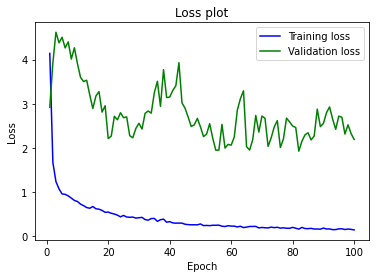

In [19]:
plotting.plot_training(history=history,
                       validation=model_validation,
                       save_name=None)

In [20]:
y_true, y_pred = utils.get_y(X_test=X_test,
                             y_test=y_test,
                             output_dim=output_dim,
                             scaler_y=scaler_y,
                             model=model)
df_pred = utils.y_to_df(y=y_pred,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)
df_true = utils.y_to_df(y=y_true,
                        output_dim=output_dim,
                        horizon=horizon,
                        index_test=index_test,
                        t_0=None if evaluate_on_all_test_data else t_0)

273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [21]:
persistence = utils.benchmark_models(data=df,
                                     target_col=target_col,
                                     horizon=horizon,
                                     train_end=train_end,
                                     test_start=test_start,
                                     output_dim=output_dim,
                                     index_test=index_test,
                                     t_0=None if evaluate_on_all_test_data else t_0)

In [22]:
results = utils.evaluate_models(pred=df_pred,
                                true=df_true,
                                persistence=persistence,
                                persistence_model=persistence_model)
results

,R^2,RMSE,MAE,Skill
Models,,,,
Main,0.925627,1.350792,0.762263,0.324888
2daysago,0.836820,2.000842,0.922861,0.000000
LinearRegression,0.723231,2.605786,1.651344,-0.302345


R^2: 0.9414296669666533
RMSE: 1.21831285975078
MAE: 0.7271280851030757


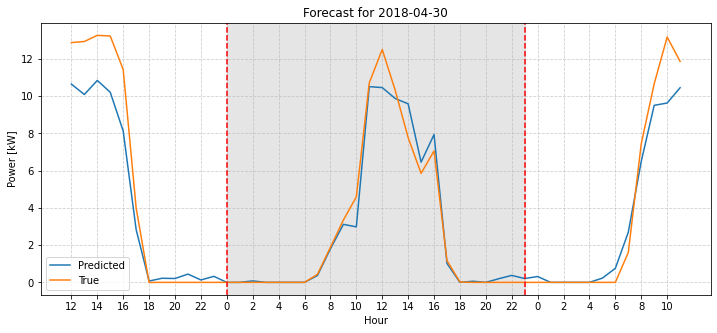

In [23]:
#date = '2018-06-06'
date = plotting.random_date(start_date=test_start, 
                            end_date=str(df.index[-1].date()))

plotting.plot_forecast(pred=df_pred,
                       true=df_true,
                       date=date,
                       horizon=horizon,
                       t_0=t_0,
                       figsize=(12,5),
                       print_metric=True,
                       grid=True)

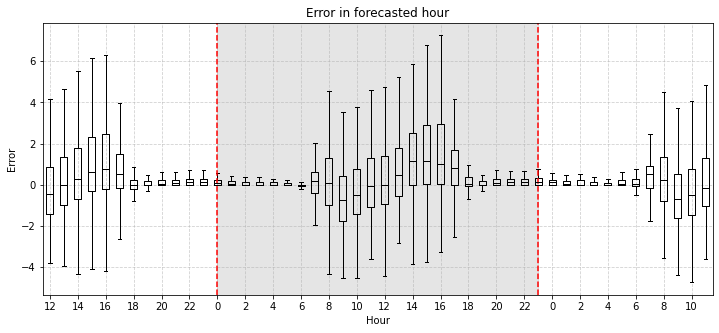

In [24]:
plotting.plot_boxplots(pred=df_pred,
                       true=df_true,
                       t_0=t_0,
                       horizon=horizon,
                       figsize=(12,5),
                       showfliers=False,
                       grid=True)

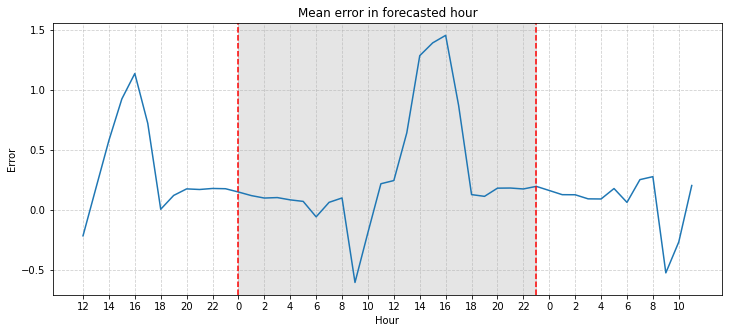

In [25]:
plotting.plot_error(pred=df_pred,
                    true=df_true,
                    t_0=t_0,
                    horizon=horizon,
                    figsize=(12,5),
                    grid=True)

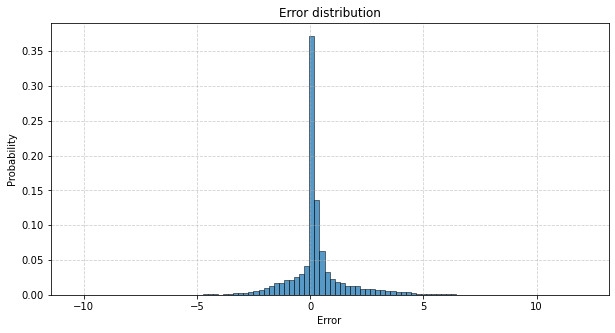

In [26]:
plotting.plot_error_distribution(pred=df_pred,
                                 true=df_true,
                                 figsize=(10,5),
                                 bins=100,
                                 t_0=t_0,
                                 grid=True)